# Projet SD-WAN-ReinforcementLearning

# Partie: Recherche opérationnelle

In [1]:
#!pip install pulp

Imports

In [2]:
import networkx as nx
import pulp
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

### Generation of random graph

In [58]:
def image_nertworkx(nodes = 25, edges = 4):
    g = nx.to_directed(nx.fast_gnp_random_graph(nodes,edges/nodes,directed=True))
    return g

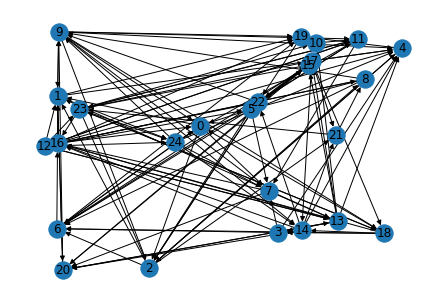

In [59]:
g = image_nertworkx()


node_pose = {}
for i in g.nodes():
    node_pose[i] = (random.uniform(1.0, 10.0),random.uniform(1.0, 10.0))

nx.draw(g,pos = node_pose, with_labels=True)
#plt.savefig("images/original.jpg")
plt.show()

### Generation of random attributes for the graph edges

In [60]:
color = {}
for i, j in g.edges:
    color[i, j] = color[j, i] = (0,0,0,0.5)
    
nx.set_edge_attributes(g, color, 'color')

In [61]:
dict_capa = {}
for i, j in g.edges:
    dict_capa[i, j] = dict_capa[j, i] = round(random.uniform(1.0, 20.0), 0)

nx.set_edge_attributes(g, dict_capa, 'capacity')

In [62]:
dict_used = {}
for i, j in g.edges:
    dict_used[i, j] = dict_used[j, i] = min(round(random.uniform(0.0, 15.0), 0),dict_capa[i, j])
    
nx.set_edge_attributes(g, dict_used, 'used')

In [63]:
dict_ratio = {}
for i, j in g.edges:
    dict_ratio[i, j] = dict_ratio[j, i] = dict_used[i, j]/dict_capa[i, j]

nx.set_edge_attributes(g, dict_ratio, 'ratio')

In [64]:
dict_delay = {}
for i, j in g.edges:
    dict_delay[i, j] = dict_delay[j, i] = round(random.uniform(1.0, 20.0), 2)

nx.set_edge_attributes(g, dict_delay, 'delay')

Calculation of variable score based on previously generated attribute "ratio"

In [65]:
big_d = {}
small_d = {}

for link in g.edges:
    small_d = {}
    small_d['Source'] = link[0]
    small_d['Ratio'] = g.edges[link]['ratio']
 
    big_d[str(link)] = small_d
temp = pd.DataFrame.from_dict(big_d,orient='index')

temp = temp.sort_values(by=['Source','Ratio'])

for i in temp.Source.unique():
    cpt=0
    for j in temp[temp['Source'] == i].index:
        cpt+=1
        temp.at[str(j),'Score'] = cpt


Have to affect it twice to get attributes value on both directions

In [66]:
for link in g.edges:
    g.edges[link]['score'] = temp.at[str(link),'Score'] 

for link in g.edges:
    if g.edges[link]['score'] != temp.at[str(link),'Score'] :
        g.edges[link]['score'] = temp.at[str(link),'Score'] 

for link in  g.edges:
    if g.edges[link]['score'] != temp.at[str(link),'Score'] :
            g.edges[link]['score'] = temp.at[str(link),'Score'] 
            

### Instantiation 

In [67]:
# instantiate
list_keys = ['shortest_path','min_delay','min_banwidth_sum','min_banwidth_square_sum','min_score','min_square_score']
dict_prob = {}
dict_prob = dict_prob.fromkeys(list_keys)

opti_path = {}
opti_path = dict([(key, []) for key in list_keys])

nodes_models = {}

dict_res = defaultdict(dict)

In [68]:
source = 0
target = 24

## MARL Part

In [159]:
iter_ = 100
iter_actuel = 0
current_iter = 0
var_dict = {}
max_move = 50
cpt = 0

expirience_replay = {}

In [70]:
def init_colors():
    color = {}
    for i, j in g.edges:
        color[i, j] = color[j, i] = (0,0,0,0.5)

    nx.set_edge_attributes(g, color, 'color')

In [71]:
def get_path_as_list_tuples(path):
    solve_var = [] 
    for i in path.split("_"):
        var = str(i).split('(')
        var = var[1].split(',')
        var[0] = int(var[0])
        var[1] = int(var[1].strip(')'))
        solve_var.append(tuple(var))
    return solve_var

In [172]:
def plot_graph(attributes):
    x = []
    y = []
    for i in range(iter_):
        x.append(dict_res[i][attributes])
        y.append(i)

    p = plt.plot(y, x)

    plt.show(p)
    plt.close()

In [73]:
def draw_path(solve_var):
        for link in g.edges:
            if link in solve_var:
                g.edges[link[0],link[1]]['color'] = (1,0,0,1) 
    
        colors = nx.get_edge_attributes(g,'color').values()

        nx.draw(g, pos = node_pose, 
            edge_color=colors, 
            with_labels=True)
        ## Save chosen path ##
        plt.show()
        #plt.savefig("imgs/Q_table/Q_table_iter_{}".format(iter))
        plt.close()
        init_colors()

In [74]:
def get_possible_actions(current_node):
    sub_list = []
    for (i,j) in g.edges:
        if i == current_node:
            sub_list.append((i,j))
    return sub_list

In [75]:
def get_list_possibles_nodes(current_node):
    sub_list = get_possible_actions(current_node)
    nodes_list = []
    for (i,j) in sub_list:
        nodes_list.append(j)
    #print(nodes_list)
    return nodes_list

In [76]:
def get_state(solve_var,add_dim = True):
    state = np.zeros((net.nodes,net.nodes), np.int8)
    for (i,j) in g.edges:
        if (i,j) in solve_var:
            state[i,j] = 1
        elif i == source:
            state[i,j] = 2
        elif j == target:
            state[i,j] = 2
        else:
            state[i,j] = 0
        if add_dim:
            state = np.expand_dims(state, axis=0)
        state = np.expand_dims(state, axis=0)
        state = np.expand_dims(state, axis=0)
        #print(state.shape)
        return state

In [77]:
def scale(X, x_min, x_max):
    nom = (X-X.min(axis=0))*(x_max-x_min)
    denom = X.max(axis=0) - X.min(axis=0)
    denom[denom==0] = 1
    return x_min + nom/denom 

In [78]:
def get_epsilon():
    return (1.03 - iter_actuel / iter_ ) 

In [79]:
def remember(solve_var):
    state = get_state(solve_var)
    state = np.expand_dims(state, axis=0)
    #print("Rmember state shap : {}".format(state.shape))
    #print("Rmember experience replay shap : {}".format(expirience_replay[current_iter].shape))
    for i in range (50):
        result = np.all(state==expirience_replay[i])
        if not result:
            expirience_replay[current_iter] = state


In [80]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense,GlobalMaxPooling1D,GlobalMaxPooling2D, LeakyReLU, Reshape, Input, ConvLSTM2D ,Flatten,Conv2D,MaxPooling2D 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [81]:
dict_model = defaultdict(dict)
for i in g.nodes:
    cpt_output = 0
    
    #print("\n   Node : {}".format(i))
    
    for ii,j in g.edges:
        if (i == ii):
            #print("Edges Output : {}".format(j))
            dict_model[i][j] = g.edges[i, j]['delay']
            cpt_output = cpt_output + 1
            
    dict_model[i]["cpt_output"] = cpt_output

In [173]:
def _build_compile_model(dict_model_local,node):
    inputs = []
    
    for i in dict_model_local.keys():
        if i != "cpt_output":
            inputs.append(dict_model[i])
    inputs.append(target)

    model = Sequential()

    #model.add(Dense(len(inputs)*2,input_shape=(len(inputs),), activation='relu'))            
    model.add(Dense(len(inputs)*2,input_shape=(1,), activation='relu'))            
    model.add(Dense(dict_model_local['cpt_output'],input_shape=(1,), activation='relu'))
    #Output
    model.add(Dense(dict_model_local['cpt_output'], activation='softmax'))

    #print(model.summary())
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    #model.save('models/model_node_{}'.format(node))
    #del model
    nodes_models[node] = model
    

        
for iii in dict_model.keys():
    if iii != "cpt_output":
        _build_compile_model(dict_model[iii],iii)
        
for iii in dict_model.keys():
    if iii != "cpt_output":
        print(nodes_models[iii].summary())

Model: "sequential_125"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_350 (Dense)            (None, 10)                20        
_________________________________________________________________
dense_351 (Dense)            (None, 4)                 44        
_________________________________________________________________
dense_352 (Dense)            (None, 4)                 20        
Total params: 84
Trainable params: 84
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_126"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_353 (Dense)            (None, 12)                24        
_________________________________________________________________
dense_354 (Dense)            (None, 5)                 65        
___________________________

In [165]:
def get_action(current_node):
    inputs = []
    
    for i in dict_model[current_node].keys():
        if i != "cpt_output":
            inputs.append(dict_model[current_node][i])
    inputs.append(target)
    expirience_replay[cpt] = inputs
    
    sub_list = get_possible_actions(current_node)
    
    if np.random.rand() <= 1 + get_epsilon(): #Epsilon
        return random.choice(sub_list)[1]
    else :
        return get_model_action(current_node,inputs)

In [166]:
def get_model_action(current_node,inputs):
    
    #print("\n inputs : {}".format(inputs))
    
    #local_model = load_model('models/model_node_{}'.format(current_node))
    
    local_model = nodes_models[current_node]
    #print(local_model.summary())
    
    
    pedicted_values = local_model.predict(inputs)
    #print(pedicted_values[0])
    list_of_output = []
    for i in dict_model[current_node].keys():
        list_of_output.append(i)
    value = np.argmax(pedicted_values[0])
    
    #print("value : {}".format(value))
    #print("list_of_output : {}".format(list_of_output))
    #print("list_of_output[value] : {}".format(list_of_output[value]))
    #print(local_model.summary())
    #del local_model
    
    return list_of_output[value]


u = 1
s = expirience_replay[2] 

print(get_model_action(u,s))
print("possible node :")
for ii,j in g.edges:
    if (u == ii):
        print(j)

In [146]:
def get_indx_from_value(current_node,value):
    list_values = []
    for i,j in g.edges:
        if (current_node == i):
            list_values.append(j)
            
    return list_values.index(value)

In [174]:
def give_final_reward(solve_var,neg_reward):
    for i in range(len(solve_var)) :
        #print("cpt = {}".format(cpt))
        
        #print("state : {}".format(state))
        action_taken = solve_var[i][1]
        current_node = solve_var[i][0]
        
        #local_model = load_model('models/model_node_{}'.format(current_node))
        local_model = nodes_models[current_node]
        
        #print("possible node : {}".format(current_node))
        
        #for ii,j in g.edges:
            #if (current_node == ii):
                #print(j)
                
        #print(local_model.summary())
        state = expirience_replay[i]
        target_model = local_model.predict(state)
        #print(target_model)
        action_taken_id = get_indx_from_value(current_node,action_taken)
        #print("target with action taken : {} before : {}".format(action_taken,target_model[action_taken]))
        if len(solve_var) != max_move:
            #print("pos reward")
            #print("before : {}".format(target[0]))
            target_model[action_taken_id] = target_model[action_taken_id] + ((max_move-i)*10/neg_reward)
            #print("A : {}".format(target[0]))
            #print("target with action taken : {} after : {}".format(action_taken,target[0][action_taken]))
        else:
            #print("neg reward")
            target_model[action_taken_id] = target_model[action_taken_id]  - max_move
        #print("target with action taken : {} after : {}".format(action_taken,target_model[action_taken]))
        #print("\n")
        local_model.fit(state,scale(target_model,0,1),epochs=1,verbose=0)
        
        #local_model.save('models/model_node_{}'.format(current_node))
        #del local_model
        
        nodes_models[current_node] = local_model
            

print(solve_var)
give_final_reward(solve_var,35)

In [ ]:
summ = 0

for ii in range(iter_):
    iter_actuel = ii + 1
    current_node = source
    path = ""
    cpt = 0
    solve_var = []
    j = source

    flag_finished = False
    while flag_finished != True and cpt < max_move:
        j = get_action (current_node)
        #j = get_model_action(current_node)
        i = current_node

        if ((i,j) in get_possible_actions(i)):
            #print("yay")
            path += "{}_".format(str((i,j)))
            solve_var.append((i,j))
            var_dict[i,j] = 1
            current_node = j
            cpt = cpt + 1
            if j == target:
                flag_finished = True
    path_ = path[:-1]
    #print(path_)
    solve_var = get_path_as_list_tuples(path_)

    ## Draw chosen path red ##
    #draw_path(solve_var)
    dict_res[iter]['Number of nodes'] = len(solve_var)

    #if iter_actuel > 90:
    #    summ = summ + len(solve_var)
    #if iter_actuel > 98:
    #     print(path)
    #summ = summ + len(solve_var)
    #print(get_epsilon())
    #print("solve_var len : {}".format(len(solve_var)))

    
    dict_res[ii]['Sum of delay'] = sum([g.edges[i, j]['delay'] for i, j in solve_var])
    dict_res[ii]['Ratio Sum'] = sum([g.edges[i, j]['ratio'] for i, j in solve_var])
    dict_res[ii]['Squared Ratio Sum'] = sum([g.edges[i, j]['ratio']**2 for i, j in solve_var])
    dict_res[ii]['Score Sum'] = sum([g.edges[i, j]['score'] for i, j in solve_var])
    dict_res[ii]['Squared Score Sum'] = sum([g.edges[i, j]['score']**2 for i, j in solve_var])

    give_final_reward(solve_var,dict_res[ii]['Sum of delay'])

#plot_graph(summ/10)
#print("{} : {}".format(test,summ/10))


In [ ]:
for ii in range(iter_):
    print(dict_res[ii]['Sum of delay'] )

In [ ]:
plot_graph('Sum of delay')